# FC base net

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import dan_utils

import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset

import ipdb

In [2]:
# 设置随机数种子
seed = 25
dan_utils.setup_seed(seed)

# Load data

In [3]:
randseed = seed
res = 11

v = pd.read_csv('../data/v_20_aggragated.csv')
v = v.rename(columns={'Unnamed: 0': 'id'})
det_with_class = pd.read_csv('../res/%i_res%i_id_402_withclass.csv'%(randseed, res), index_col=0)

v['class_i'] = ''
for i in range(len(v)):
    v.loc[i, 'class_i'] = det_with_class[det_with_class['id']==v.loc[i, 'id']].iloc[0, 5]  # 5 stands for 'class_i'

num_class = det_with_class['class_i'].drop_duplicates().size

v_class = []
for i in range(num_class):
    v_class.append(v[v['class_i']==i])

print('There are %i class(es)'%num_class)

dist_mat = pd.read_csv('../data/dist_mat.csv', index_col=0)
id_info = pd.read_csv('../data/id2000.csv', index_col=0)
dist_mat.index = id_info['id2']
dist_mat.columns = id_info['id2']
for i in range(len(dist_mat)):
    for j in range(len(dist_mat)):
        if i==j:
            dist_mat.iloc[i, j] = 0

near_id = pd.DataFrame(np.argsort(np.array(dist_mat)), index = id_info['id2'], columns = id_info['id2'])

seg = pd.read_csv('../data/segement.csv', header=None)
num_dets = 30

det_list_class = []
for i in range(num_class):
    det_list_class_temp, v_class_temp = dan_utils.get_class_with_node(seg, v_class[i])
    det_list_class.append(det_list_class_temp)
    v_class_temp = v_class_temp[v_class_temp['id'].isin(det_list_class_temp[:num_dets])]
    v_class[i] = v_class_temp

near_road_set = []
for i in range(num_class):
    near_road_set.append(dan_utils.rds_mat(dist_mat, det_list_class[i][:num_dets], seg))



There are 5 class(es)


C:\Users\10169\anaconda3\envs\dan_traff\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


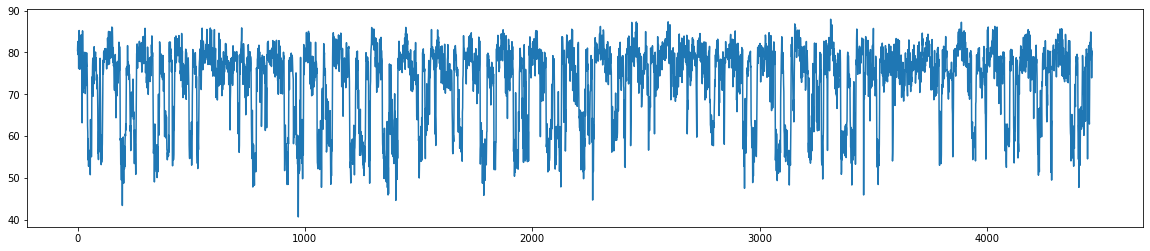

In [4]:
plt.figure(figsize=[20, 4])
plt.plot(range(len(v_class[4].iloc[0, 2:-1])), v_class[4].iloc[0, 2:-1])

In [5]:
# in this case, only target data is accessible
tar_flow, tar_min, tar_max = dan_utils.norm_data(np.array(v_class[1].iloc[:, 4466-144*10-1:4466-144-1], dtype=float))

In [6]:
tar_flow.shape

(30, 1296)

# Data assembling

In [7]:
def sliding_window(data, window_size, prop):
    pred_samp = 3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # "data" should be 1-D vector
    data = data.T
    data_out = []
    label_out = []
    for i in range(data.shape[0] - window_size - pred_samp):
        data_out.append(data[i : i + window_size])
        label_out.append(data[i + window_size + 1: i + window_size + 1 + pred_samp])  # to predict the next 3 flows
    data_out = np.array(data_out)
    label_out = np.array(label_out)
    
    train_data_out = torch.tensor(data_out[:int(data_out.shape[0]*prop), :], dtype=torch.float32).to(device)
    train_label_out = torch.tensor(label_out[:int(data_out.shape[0]*prop)], dtype=torch.float32).to(device)
    val_data_out = torch.tensor(data_out[int(data_out.shape[0]*prop):, :], dtype=torch.float32).to(device)
    val_label_out = torch.tensor(label_out[int(data_out.shape[0]*prop):], dtype=torch.float32).to(device)
    
    train_data_out = torch.transpose(train_data_out, 1, 2)
    train_label_out = torch.transpose(train_label_out, 1, 2)
    val_data_out = torch.transpose(val_data_out, 1, 2)
    val_label_out = torch.transpose(val_label_out, 1, 2)
    
    return train_data_out, train_label_out, val_data_out, val_label_out

In [8]:
window_size = 10
batch_size = 57600
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tar_train_data, tar_train_label, tar_val_data, tar_val_label = sliding_window(tar_flow, window_size, 0.3)

tar_train_loader = torch.utils.data.DataLoader(
    TensorDataset(tar_train_data, tar_train_label), batch_size, shuffle=True
)

tar_iter = iter(tar_train_loader)

In [9]:
print(tar_train_data.shape)
print(tar_train_label.shape)
print(tar_val_data.shape)
print(tar_val_label.shape)

torch.Size([384, 30, 10])
torch.Size([384, 30, 3])
torch.Size([899, 30, 10])
torch.Size([899, 30, 3])


# FC network (base)

In [10]:
class traffic_base_net(nn.Module):
    def __init__(self, inp_dim, out_dim, hid_dim):
        super(traffic_base_net, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(inp_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim*2),
            nn.ReLU(),
            nn.Linear(hid_dim*2, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim),
            nn.ReLU(),
        )  # regression
    
    def forward(self, x):
        # input size: (batchsize, seq_len, input_dim)
#         output size: (batchsize, seq_len, hid_dim)
        # y = self.lstm(x)[0]  # y, (h, c) = self.rnn(x)
#         ipdb.set_trace()
        y = self.fc(x)  # fully connected layer
        
        return y

# Training on target data

In [11]:
inp_dim = window_size
out_dim = 3
hid_dim = 8
# layers = 3

In [12]:
traff_node_base = traffic_base_net(inp_dim, out_dim, hid_dim).to(device)

loss_func = nn.MSELoss()
val_loss_set = []
train_loss_set = []

#summary(traff_node_dannet, input_size=(batch_size, window_size), device=device)

In [13]:
optimizer = optim.Adam(traff_node_base.parameters())

In [14]:
traff_node_base.train()

epochs = 300

# assert len(src_loader) == len(tar_loader)
   
for e in range(epochs):
    #ipdb.set_trace()
    for i in range(len(tar_train_loader)):
        try:
            tar_data, tar_label = tar_iter.next()
        except:
            tar_iter = iter(tar_train_loader)
            tar_data, tar_label = tar_iter.next()
        
        tar_out = traff_node_base(tar_data)
        #ipdb.set_trace()
        loss = loss_func(tar_out, tar_label)  # target dataset loss

        val_out = traff_node_base(tar_val_data)
        val_loss = loss_func(val_out, tar_val_label)
        #ipdb.set_trace()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        val_loss_set.append(val_loss.cpu().detach().numpy())
        train_loss_set.append(loss.cpu().detach().numpy())
    if e%50==0:
        print('Epoch %i success, val loss:%.5f, train loss:%.5f'%(e, val_loss.cpu().detach().numpy(), loss.cpu().detach().numpy()))

Epoch 0 success, val loss:0.31153, train loss:0.30483
Epoch 50 success, val loss:0.21485, train loss:0.20997
Epoch 100 success, val loss:0.19158, train loss:0.18808
Epoch 150 success, val loss:0.18749, train loss:0.18398
Epoch 200 success, val loss:0.18452, train loss:0.18117
Epoch 250 success, val loss:0.18252, train loss:0.17942


# Visualization

In [15]:
def plot_loss(val, train, title):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.plot(val)
    ax1.set_xlabel('Batches')
    ax1.set_ylabel('MSELoss')
    ax1.set_ylim([0, max(val)])
    ax1.set_title('Validation loss')
    ax1.grid()
    ax2 = fig.add_subplot(122)
    ax2.plot(train)
    ax2.set_xlabel('Batches')
    ax2.set_ylabel('MSELoss')
    ax2.set_ylim([0, max(train)])
    ax2.set_title('Train loss')
    ax2.grid()
    plt.suptitle(title)

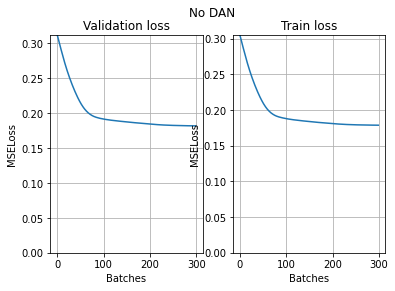

In [16]:
plot_loss(val_loss_set, train_loss_set, 'No DAN')

Text(0.5, 1.0, 'Target dataset')

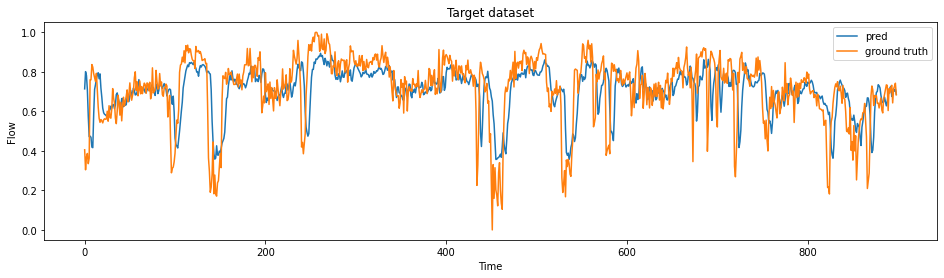

In [17]:
plt.figure(figsize=[16,4])
plt.plot(val_out[:, 0, -1].cpu().detach().numpy(), label='pred')
plt.plot(tar_val_label[:, 0, -1].cpu().detach().numpy(), label='ground truth')
plt.legend()
plt.xlabel('Time')  # time gran: 15 min
plt.ylabel('Flow')
plt.title('Target dataset')

# Evaluation

In [18]:
# traff_node_dannet = torch.load('./model/traff_node_dannet.pth')
traff_node_base.eval()

val_out = traff_node_base(tar_val_data).cpu().detach().numpy()
# val_out_denormed = dan_utils.denorm_data(val_out, tar_min, tar_max).cpu().detach().numpy()
# tar_val_label_denormed = dan_utils.denorm_data(tar_val_label, tar_min, tar_max).cpu().detach().numpy()

print('MAPE: %.5f'%dan_utils.mape_loss_func(val_out, tar_val_label.cpu().detach().numpy()))
print('SMAPE: %.5f'%dan_utils.smape_loss_func(val_out, tar_val_label.cpu().detach().numpy()))
print('MAE: %.5f'%dan_utils.mae_loss_func(val_out, tar_val_label.cpu().detach().numpy()))

# save model
torch.save(traff_node_base.state_dict(), '../model/base_FC_mape=%.5f.h5'%dan_utils.mape_loss_func(val_out, tar_val_label.cpu().detach().numpy()))

MAPE: 0.45159
SMAPE: 0.75785
MAE: 0.28332


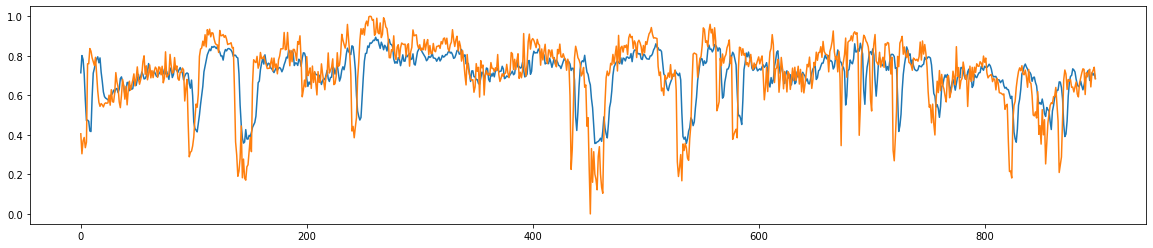

In [19]:
plt.figure(figsize=[20, 4])
plt.plot(val_out[:, 0, 2])
plt.plot(tar_val_label.cpu().detach().numpy()[:, 0, 2])

In [21]:
tar_val_label.shape

torch.Size([899, 30, 3])

In [22]:
val_out.shape

(899, 30, 3)